In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics#, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import sys
import warnings
import itertools

if not sys.warnoptions:
    warnings.simplefilter("ignore")

path = "/home/darragh/avito/data/"
#path = '/Users/dhanley2/Documents/avito/data/'
#path = '/home/ubuntu/avito/data/'
#data_path = 'data/'

In [2]:
#lgb25 = pd.read_csv('../lgCV_2505.csv.gz', compression='gzip')
lgb02A = pd.read_csv(path+'../sub/lgCV_0206A.csv.gz', compression='gzip')
lgb09 = pd.read_csv(path+'../sub/lgCV_0906.csv.gz', compression='gzip')
lgb10 = pd.read_csv(path+'../sub/lgCV_1006.csv.gz', compression='gzip')
lgb11A= pd.read_csv(path+'../sub/lgCV_1106A.csv.gz', compression='gzip')
lgb11D= pd.read_csv(path+'../sub/lgCV_1106D.csv.gz', compression='gzip')
lgb14= pd.read_csv(path+'../sub/lgCV_1406.csv.gz', compression='gzip')
lgb14A= pd.read_csv(path+'../sub/lgCV_1406A.csv.gz', compression='gzip')
lgb27 = pd.read_csv(path+'../sub/lgCV_2705B.csv.gz', compression='gzip')
lgb31 = pd.read_csv(path+'../sub/lgCV_3105.csv.gz', compression='gzip')
lgb02 = pd.read_csv(path+'../sub/lgCV_0206.csv.gz', compression='gzip')
lgb17 = pd.read_csv(path+'../sub/lgCV_1706.csv.gz', compression='gzip')
lgb19 = pd.read_csv(path+'../sub/lgCV_1906.csv.gz', compression='gzip')
lgb20 = pd.read_csv(path+'../sub/lgCV_2006.csv.gz', compression='gzip')
lgb20C = pd.read_csv(path+'../sub/lgCV_2006C.csv.gz', compression='gzip')
lgb20B = pd.read_csv(path+'../sub/lgCV_2006B.csv.gz', compression='gzip')
lgb20AA = pd.read_csv(path+'../sub/lgCV_2006AA.csv.gz', compression='gzip')
lgb19A= pd.read_csv(path+'../sub/lgCV_1906A.csv.gz', compression='gzip')
rnn =   pd.read_csv(path+'../sub/rnnCV_2805.csv.gz', compression='gzip')
rnn27 = pd.read_csv(path+'../sub/rnnCV_2705A.csv.gz', compression='gzip')
rnn12 = pd.read_csv(path+'../sub/rnnCV_1206.csv.gz', compression='gzip')
rnn12 = pd.read_csv(path+'../sub/rnnCV_1206.csv.gz', compression='gzip')
mlp =   pd.read_csv(path+'../sub/mlpCV_2505.csv.gz', compression='gzip')
rmlp23A =   pd.read_csv(path+'../sub/rmlp5CV_2306A.csv.gz', compression='gzip')
rmlp23 =   pd.read_csv(path+'../sub/rmlp5CV_2306.csv.gz', compression='gzip')
rdgv19 =   pd.read_csv(path+'../sub/rdgv19CV_1606.csv.gz', compression='gzip')
rdgv20 =   pd.read_csv(path+'../sub/rdg5CV_2006B.csv.gz', compression='gzip')
rdgv23 =   pd.read_csv(path+'../sub/rdg5CV_2306.csv.gz', compression='gzip')
rdgv23A =   pd.read_csv(path+'../sub/rdg5CV_2306A.csv.gz', compression='gzip')


truth = pd.read_csv(path+'train.csv.zip', compression='zip', parse_dates = ["activation_date"])
y =     truth['deal_probability'].values
truth.drop('deal_probability', 1)
test =  pd.read_csv(path+'test.csv.zip', compression='zip', parse_dates = ["activation_date"])
test['deal_probability']=float('NAN') 
truth = pd.concat([truth,test[truth.columns]],axis=0)

In [3]:
entropy = pd.read_csv(path+'../features/user_entropy_2306.gz', compression='gzip')
entropy.drop(['user_id', 'index'], 1, inplace = True)
entropy.head()

,user_id__category_name__entropy,user_id__parent_category_name__entropy,user_id__title__entropy,user_id__param_1__entropy,user_id__city__entropy,user_id__param_2__entropy,user_id__param_3__entropy,user_id__activation_date__entropy
0,0.000000,0.000000,0.636514,0.636514,0.0,0.000000,0.000000,1.098612
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.325083,0.000000,2.163956,0.325083,0.0,2.163956,0.000000,1.504788
3,1.931448,0.935704,3.459348,2.538687,0.0,1.342766,0.737584,0.937894
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [4]:
lgb14['deal_probability'] =  ( lgb14['deal_probability'].values + lgb14A['deal_probability'].values)*0.5
lgb17['deal_probability'] =  ( lgb17['deal_probability'].values + lgb19['deal_probability'].values)*0.25
lgb20['deal_probability'] =  ( lgb20['deal_probability'].values) * 0.5


In [5]:
#img_cts = truth['image_top_1'].value_counts().reset_index()
#truth['image_top_big'] = 'lo_count'
#big_top_1 = img_cts[img_cts['image_top_1']>5000]['index'].tolist()
#idx = truth['image_top_1'].isin(big_top_1)
#truth['image_top_big'][idx] = truth['image_top_1'][idx].astype(str).values

def keep_big(df, col, cutoff):
    cts = df[col].value_counts().reset_index()
    df[col+'_big'] = 'lo_count'
    big = cts[cts[col]>cutoff]['index'].tolist()
    idx = df[col].isin(big)
    df[col+'_big'][idx] = df[col][idx].astype(str).values
    return df[col+'_big'].values
truth['image_top_1_big'] = keep_big(truth, 'image_top_1', 5000)
truth['param_1_big'] = keep_big(truth, 'param_1', 5000)
truth['param_2_big'] = keep_big(truth, 'param_2', 5000)
truth['param_3_big'] = keep_big(truth, 'param_3', 5000)
truth['city_big'] = keep_big(truth, 'city', 5000)

In [6]:
truth[[c for c in truth.columns if 'big' in c]].head()

,image_top_1_big,param_1_big,param_2_big,param_3_big,city_big
0,lo_count,Постельные принадлежности,lo_count,lo_count,Екатеринбург
1,lo_count,Другое,lo_count,lo_count,Самара
2,lo_count,lo_count,lo_count,lo_count,Ростов-на-Дону
3,796.0,Автомобильные кресла,lo_count,lo_count,Набережные Челны
4,2264.0,С пробегом,ВАЗ (LADA),lo_count,Волгоград


In [7]:
#lgb25.rename(columns={'deal_probability': 'lgb25_preds' }, inplace=True)
lgb31.rename(columns={'deal_probability': 'lgb31_preds' }, inplace=True)
lgb27.rename(columns={'deal_probability': 'lgb27_preds' }, inplace=True)
lgb02.rename(columns={'deal_probability': 'lgb02_preds' }, inplace=True)
lgb09.rename(columns={'deal_probability': 'lgb09_preds' }, inplace=True)
lgb10.rename(columns={'deal_probability': 'lgb10_preds' }, inplace=True)
lgb11D.rename(columns={'deal_probability': 'lgb11D_preds' }, inplace=True)
lgb11A.rename(columns={'deal_probability': 'lgb11A_preds' }, inplace=True)
lgb14.rename(columns={'deal_probability': 'lgb14_preds' }, inplace=True)
lgb17.rename(columns={'deal_probability': 'lgb17_preds' }, inplace=True)
lgb20.rename(columns={'deal_probability': 'lgb20_preds' }, inplace=True)
lgb20C.rename(columns={'deal_probability': 'lgb20C_preds' }, inplace=True)
lgb20B.rename(columns={'deal_probability': 'lgb20B_preds' }, inplace=True)
lgb20AA.rename(columns={'deal_probability': 'lgb20AA_preds' }, inplace=True)
lgb19A.rename(columns={'deal_probability': 'lgb19A_preds' }, inplace=True)
lgb02A.rename(columns={'deal_probability': 'lgb02A_preds' }, inplace=True)
rnn27.rename(columns={'deal_probability': 'rnn27_preds' }, inplace=True)
rnn12.rename(columns={'deal_probability': 'rnn12_preds' }, inplace=True)
rdgv19.rename(columns={'deal_probability': 'rdgv19_preds' }, inplace=True)
rdgv20.rename(columns={'deal_probability': 'rdgv20_preds' }, inplace=True)
rdgv23.rename(columns={'deal_probability': 'rdgv23_preds' }, inplace=True)
rdgv23A.rename(columns={'deal_probability': 'rdgv23A_preds' }, inplace=True)
rmlp23.rename(columns={'deal_probability': 'rmlp23_preds' }, inplace=True)
rmlp23A.rename(columns={'deal_probability': 'rmlp23A_preds' }, inplace=True)
mlp.rename(columns={'deal_probability': 'mlp_preds' }, inplace=True)
preds_df = lgb27.merge(rnn, on='item_id')\
                .merge(mlp, on='item_id')\
                .merge(rmlp23, on='item_id')\
                .merge(rmlp23A, on='item_id')\
                .merge(lgb31, on='item_id')\
                .merge(lgb02, on='item_id')\
                .merge(lgb09, on='item_id')\
                .merge(lgb10, on='item_id')\
                .merge(lgb11A, on='item_id')\
                .merge(lgb11D, on='item_id')\
                .merge(lgb14, on='item_id')\
                .merge(lgb17, on='item_id')\
                .merge(lgb20, on='item_id')\
                .merge(lgb20C, on='item_id')\
                .merge(lgb20B, on='item_id')\
                .merge(lgb20AA, on='item_id')\
                .merge(lgb19A, on='item_id')\
                .merge(lgb02A, on='item_id')\
                .merge(rnn27, on='item_id')\
                .merge(rnn12, on='item_id')\
                .merge(rdgv19, on='item_id')\
                .merge(rdgv20, on='item_id')\
                .merge(rdgv23, on='item_id')\
                .merge(rdgv23A, on='item_id')\
                .merge(truth, on='item_id',how='left')

In [8]:
pred_cols = [col for col in preds_df.columns if ('_preds' in col) \
             and ('lgb27' not in col) and ('lgb02_' not in col) and ('lgb11A_' not in col) \
             and ('rdgv19_' not in col) and ('lgb17_' not in col) and ('lgb11A_'  not in col) \
             and ('lgb09_'  not in col)]

preds_df['preds_sum'] = preds_df[pred_cols].sum(axis=1)
pred_cols

['rnn_preds',
 'mlp_preds',
 'rmlp23_preds',
 'rmlp23A_preds',
 'lgb31_preds',
 'lgb10_preds',
 'lgb11D_preds',
 'lgb14_preds',
 'lgb20_preds',
 'lgb20C_preds',
 'lgb20B_preds',
 'lgb20AA_preds',
 'lgb19A_preds',
 'lgb02A_preds',
 'rnn27_preds',
 'rnn12_preds',
 'rdgv20_preds',
 'rdgv23_preds',
 'rdgv23A_preds']

In [9]:
preds_df['price'].fillna(-1,inplace=True)
preds_df['_max_'] = np.max(np.array([preds_df[col] for col in pred_cols]),axis=0).astype(np.float32)
preds_df['_min_'] = np.min(np.array([preds_df[col] for col in pred_cols]),axis=0).astype(np.float32)
preds_df['_avg_'] = np.mean(np.array([preds_df[col] for col in pred_cols]),axis=0).astype(np.float32)
preds_df['_med_'] = np.median(np.array([preds_df[col] for col in pred_cols]),axis=0).astype(np.float32)
preds_df['_std_'] = np.std(np.array([preds_df[col] for col in pred_cols]),axis=0).astype(np.float32)

In [10]:
#for v in ['rnn', 'rdg', 'lgb1', 'lgb2']:
#    cols = [col for col in preds_df.columns if v in col]
#    preds_df[v+'_max_'] = np.max(np.array([preds_df[col] for col in cols]),axis=0).astype(np.float32)
#    preds_df[v+'_min_'] = np.min(np.array([preds_df[col] for col in cols]),axis=0).astype(np.float32)
#    preds_df[v+'_avg_'] = np.mean(np.array([preds_df[col] for col in cols]),axis=0).astype(np.float32)
#    preds_df[v+'_med_'] = np.median(np.array([preds_df[col] for col in cols]),axis=0).astype(np.float32)
#    preds_df[v+'_std_'] = np.std(np.array([preds_df[col] for col in cols]),axis=0).astype(np.float32)

In [11]:
import itertools
for p1, p2 in itertools.combinations(pred_cols, 2):
    print('difference_%s__%s'%(p1,p2))
    preds_df['difference_%s__%s'%(p1,p2)] = (preds_df[p2] - preds_df[p1]).astype(np.float32)
    preds_df['sums_%s__%s'%(p1,p2)] = (preds_df[p2] + preds_df[p1]).astype(np.float32)

difference_rnn_preds__mlp_preds
difference_rnn_preds__rmlp23_preds
difference_rnn_preds__rmlp23A_preds
difference_rnn_preds__lgb31_preds
difference_rnn_preds__lgb10_preds
difference_rnn_preds__lgb11D_preds
difference_rnn_preds__lgb14_preds
difference_rnn_preds__lgb20_preds
difference_rnn_preds__lgb20C_preds
difference_rnn_preds__lgb20B_preds
difference_rnn_preds__lgb20AA_preds
difference_rnn_preds__lgb19A_preds
difference_rnn_preds__lgb02A_preds
difference_rnn_preds__rnn27_preds
difference_rnn_preds__rnn12_preds
difference_rnn_preds__rdgv20_preds
difference_rnn_preds__rdgv23_preds
difference_rnn_preds__rdgv23A_preds
difference_mlp_preds__rmlp23_preds
difference_mlp_preds__rmlp23A_preds
difference_mlp_preds__lgb31_preds
difference_mlp_preds__lgb10_preds
difference_mlp_preds__lgb11D_preds
difference_mlp_preds__lgb14_preds
difference_mlp_preds__lgb20_preds
difference_mlp_preds__lgb20C_preds
difference_mlp_preds__lgb20B_preds
difference_mlp_preds__lgb20AA_preds
difference_mlp_preds__lgb19A

In [12]:
for col in entropy.columns:
    print(col)
    preds_df[col] = (entropy[col].values).astype(np.float32)
del entropy
import gc
gc.collect()

user_id__category_name__entropy
user_id__parent_category_name__entropy
user_id__title__entropy
user_id__param_1__entropy
user_id__city__entropy
user_id__param_2__entropy
user_id__param_3__entropy
user_id__activation_date__entropy


304

In [13]:
gc.collect()

0

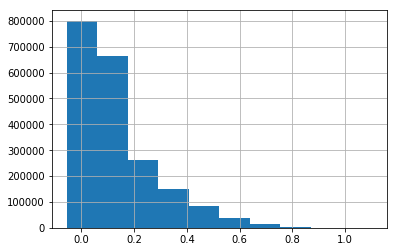

In [14]:
%matplotlib inline
preds_df['rmlp23A_preds'].hist()

In [15]:
preds_df.head()

,item_id,lgb27_preds,rnn_preds,mlp_preds,rmlp23_preds,rmlp23A_preds,lgb31_preds,lgb02_preds,lgb09_preds,lgb10_preds,...,difference_rdgv23_preds__rdgv23A_preds,sums_rdgv23_preds__rdgv23A_preds,user_id__category_name__entropy,user_id__parent_category_name__entropy,user_id__title__entropy,user_id__param_1__entropy,user_id__city__entropy,user_id__param_2__entropy,user_id__param_3__entropy,user_id__activation_date__entropy
0,b912c3c6a6ad,0.091656,0.069891,0.091223,0.045202,0.060752,0.083219,0.090855,0.109624,0.107764,...,0.015332,0.181417,0.000000,0.000000,0.636514,0.636514,0.0,0.000000,0.000000,1.098612
1,2dac0150717d,0.147801,0.075968,0.211844,0.195085,0.139649,0.157973,0.119609,0.157466,0.161107,...,0.021086,0.318532,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,ba83aefab5dc,0.186261,0.167167,0.236579,0.207214,0.175712,0.227048,0.258980,0.245236,0.219107,...,-0.008940,0.317700,0.325083,0.000000,2.163956,0.325083,0.0,2.163956,0.000000,1.504788
3,02996f1dd2ea,0.241699,0.260876,0.383699,0.337217,0.222824,0.231447,0.284130,0.289101,0.255519,...,-0.027563,0.645042,1.931448,0.935704,3.459348,2.538687,0.0,1.342766,0.737584,0.937894
4,7c90be56d2ab,0.407423,0.431520,0.420657,0.511901,0.522890,0.412563,0.430581,0.511145,0.511676,...,0.042827,0.813152,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


### Train scores

In [16]:
pred_cols = [col for col in preds_df.columns if ('preds' in col) 
             and ('difference' not in col) 
             and ('sum' not in col)]
pred_cols

['lgb27_preds',
 'rnn_preds',
 'mlp_preds',
 'rmlp23_preds',
 'rmlp23A_preds',
 'lgb31_preds',
 'lgb02_preds',
 'lgb09_preds',
 'lgb10_preds',
 'lgb11A_preds',
 'lgb11D_preds',
 'lgb14_preds',
 'lgb17_preds',
 'lgb20_preds',
 'lgb20C_preds',
 'lgb20B_preds',
 'lgb20AA_preds',
 'lgb19A_preds',
 'lgb02A_preds',
 'rnn27_preds',
 'rnn12_preds',
 'rdgv19_preds',
 'rdgv20_preds',
 'rdgv23_preds',
 'rdgv23A_preds']

In [17]:
idx = preds_df['deal_probability']==preds_df['deal_probability']
print(idx.value_counts())
for col in [c for c in preds_df.columns if ('_preds' in c) and ('difference' not in c) and ('sum' not in c)]:
    print('RMSE %s: '%(col), np.sqrt(metrics.mean_squared_error(preds_df['deal_probability'][idx].values, preds_df[col][idx].values)))

True     1503424
False     508438
Name: deal_probability, dtype: int64
RMSE lgb27_preds:  0.21681527582821059
RMSE rnn_preds:  0.21771476573780568
RMSE mlp_preds:  0.2187544351068867
RMSE rmlp23_preds:  0.21900188939527213
RMSE rmlp23A_preds:  0.21686466841688262
RMSE lgb31_preds:  0.21681135578306754
RMSE lgb02_preds:  0.21625386267187377
RMSE lgb09_preds:  0.21581543265040168
RMSE lgb10_preds:  0.21533498019117664
RMSE lgb11A_preds:  0.21403812331071156
RMSE lgb11D_preds:  0.21392147604708842
RMSE lgb14_preds:  0.21329729304260686
RMSE lgb17_preds:  0.21311496843894262
RMSE lgb20_preds:  0.21300538173982395
RMSE lgb20C_preds:  0.21333102462329412
RMSE lgb20B_preds:  0.21317314259822653
RMSE lgb20AA_preds:  0.21329931538907382
RMSE lgb19A_preds:  0.21341739569735188
RMSE lgb02A_preds:  0.21627136604335995
RMSE rnn27_preds:  0.21698040871120608
RMSE rnn12_preds:  0.2167114508342396
RMSE rdgv19_preds:  0.24593955235646558
RMSE rdgv20_preds:  0.22348322742981183
RMSE rdgv23_preds:  0.225

In [18]:
foldls = [["2017-03-15", "2017-03-16", "2017-03-17"], \
       ["2017-03-18", "2017-03-19", "2017-03-20"], \
       ["2017-03-21", "2017-03-22", "2017-03-23"], \
       ["2017-03-24", "2017-03-25", "2017-03-26"], \
        ["2017-03-27", "2017-03-28", "2017-03-29", \
            "2017-03-30", "2017-03-31", "2017-04-01", \
            "2017-04-02", "2017-04-03","2017-04-07"]]
foldls = [[pd.to_datetime(d) for d in f] for f in foldls]
preds_df['fold'] = -1
for t, fold in enumerate(foldls):
    preds_df['fold'][preds_df.activation_date.isin(fold)] = t

In [19]:
scores = []
for col in [c for c in preds_df.columns if ('_preds' in c) \
            and ('difference' not in c) \
            and ('sum' not in c)]:
    lstmp = [col]
    for i in range(5):
        idx = preds_df['fold']==i
        lstmp.append(np.sqrt(metrics.mean_squared_error(preds_df['deal_probability'][idx].values, \
                                                        preds_df[col][idx].values)))
    scores.append(lstmp)
pd.DataFrame(scores, columns = ['Model']+['Fold%s'%(i) for i in range(5)])

,Model,Fold0,Fold1,Fold2,Fold3,Fold4
0,lgb27_preds,0.216848,0.217096,0.217923,0.217597,0.213692
1,rnn_preds,0.218756,0.218966,0.215764,0.219554,0.214747
2,mlp_preds,0.219660,0.220088,0.216672,0.220347,0.216385
3,rmlp23_preds,0.220051,0.219853,0.217173,0.220605,0.216757
4,rmlp23A_preds,0.217566,0.217903,0.214987,0.218466,0.214904
5,lgb31_preds,0.216537,0.216643,0.219230,0.217169,0.213430
6,lgb02_preds,0.216371,0.216447,0.217354,0.217032,0.213158
7,lgb09_preds,0.215514,0.215678,0.218418,0.216073,0.212293
8,lgb10_preds,0.215240,0.215533,0.217072,0.215802,0.212023
9,lgb11A_preds,0.215011,0.215205,0.211879,0.215771,0.211735


### Correlations in test and train

In [20]:
# Test correlation
preds_df[~preds_df['deal_probability'].isnull()][[c for c in preds_df.columns if ('_preds' in c) \
                                                  and ('difference' not in c) and ('sum' not in c) ]].corr()

,lgb27_preds,rnn_preds,mlp_preds,rmlp23_preds,rmlp23A_preds,lgb31_preds,lgb02_preds,lgb09_preds,lgb10_preds,lgb11A_preds,...,lgb20B_preds,lgb20AA_preds,lgb19A_preds,lgb02A_preds,rnn27_preds,rnn12_preds,rdgv19_preds,rdgv20_preds,rdgv23_preds,rdgv23A_preds
lgb27_preds,1.000000,0.915952,0.919171,0.923268,0.935301,0.990750,0.988682,0.978331,0.978298,0.966819,...,0.954982,0.958141,0.957731,0.983143,0.916804,0.920576,0.568406,0.889293,0.898176,0.890177
rnn_preds,0.915952,1.000000,0.929710,0.910552,0.911775,0.910602,0.913307,0.908867,0.913286,0.915655,...,0.909274,0.910838,0.910086,0.911443,0.985360,0.978274,0.551100,0.870967,0.879138,0.864475
mlp_preds,0.919171,0.929710,1.000000,0.917184,0.913614,0.914307,0.916343,0.909521,0.913883,0.915367,...,0.907368,0.909956,0.908837,0.913600,0.925010,0.929518,0.577280,0.894224,0.909667,0.894730
rmlp23_preds,0.923268,0.910552,0.917184,1.000000,0.968238,0.920488,0.922523,0.916828,0.923118,0.931191,...,0.927988,0.926145,0.924119,0.918191,0.912801,0.915215,0.571342,0.928160,0.912539,0.902845
rmlp23A_preds,0.935301,0.911775,0.913614,0.968238,1.000000,0.932417,0.934372,0.933147,0.938928,0.944627,...,0.945115,0.942924,0.939758,0.930770,0.914086,0.917394,0.566375,0.927046,0.894988,0.903611
lgb31_preds,0.990750,0.910602,0.914307,0.920488,0.932417,1.000000,0.991984,0.981891,0.981375,0.966656,...,0.955024,0.958066,0.957796,0.986851,0.914204,0.916939,0.570034,0.886311,0.895124,0.889490
lgb02_preds,0.988682,0.913307,0.916343,0.922523,0.934372,0.991984,1.000000,0.982596,0.982052,0.970858,...,0.958416,0.962551,0.962391,0.987434,0.916726,0.920105,0.567698,0.887142,0.894194,0.889161
lgb09_preds,0.978331,0.908867,0.909521,0.916828,0.933147,0.981891,0.982596,1.000000,0.990447,0.976755,...,0.961188,0.966872,0.968260,0.988708,0.912375,0.915090,0.560909,0.882808,0.882028,0.882791
lgb10_preds,0.978298,0.913286,0.913883,0.923118,0.938928,0.981375,0.982052,0.990447,1.000000,0.982841,...,0.967745,0.972605,0.973449,0.985858,0.916436,0.920034,0.562639,0.888719,0.889426,0.889637
lgb11A_preds,0.966819,0.915655,0.915367,0.931191,0.944627,0.966656,0.970858,0.976755,0.982841,1.000000,...,0.978661,0.983654,0.984745,0.971893,0.918727,0.923137,0.558477,0.891140,0.889225,0.889733


In [21]:
# Train correlation
preds_df[preds_df['deal_probability'].isnull()][[c for c in preds_df.columns if ('_preds' in c)  \
                                                  and ('difference' not in c) and ('sum' not in c) ]].corr()

,lgb27_preds,rnn_preds,mlp_preds,rmlp23_preds,rmlp23A_preds,lgb31_preds,lgb02_preds,lgb09_preds,lgb10_preds,lgb11A_preds,...,lgb20B_preds,lgb20AA_preds,lgb19A_preds,lgb02A_preds,rnn27_preds,rnn12_preds,rdgv19_preds,rdgv20_preds,rdgv23_preds,rdgv23A_preds
lgb27_preds,1.000000,0.930288,0.924283,0.931424,0.943034,0.991439,0.989502,0.979729,0.979341,0.975840,...,0.964793,0.967953,0.967059,0.984742,0.930692,0.932951,0.571110,0.893300,0.897237,0.892067
rnn_preds,0.930288,1.000000,0.939951,0.919523,0.923017,0.927835,0.927867,0.926158,0.928367,0.927119,...,0.921521,0.923007,0.922491,0.928496,0.988198,0.984113,0.559376,0.884649,0.889785,0.878241
mlp_preds,0.924283,0.939951,1.000000,0.916842,0.917340,0.922413,0.921927,0.918064,0.920496,0.919275,...,0.912745,0.915276,0.914513,0.922121,0.935069,0.936609,0.561935,0.896161,0.904597,0.893696
rmlp23_preds,0.931424,0.919523,0.916842,1.000000,0.971878,0.932502,0.931169,0.929116,0.933392,0.934328,...,0.931904,0.930243,0.928174,0.930408,0.921868,0.921978,0.577149,0.931776,0.914764,0.906431
rmlp23A_preds,0.943034,0.923017,0.917340,0.971878,1.000000,0.943178,0.942330,0.944077,0.948552,0.949365,...,0.949610,0.947574,0.944900,0.941454,0.925788,0.927130,0.565401,0.931514,0.898456,0.909741
lgb31_preds,0.991439,0.927835,0.922413,0.932502,0.943178,1.000000,0.993168,0.982874,0.982519,0.978877,...,0.968049,0.970928,0.970094,0.988043,0.931468,0.932981,0.572757,0.893488,0.897623,0.894707
lgb02_preds,0.989502,0.927867,0.921927,0.931169,0.942330,0.993168,1.000000,0.984427,0.983525,0.980105,...,0.968556,0.972462,0.971908,0.989577,0.931447,0.933333,0.570342,0.891668,0.894092,0.891804
lgb09_preds,0.979729,0.926158,0.918064,0.929116,0.944077,0.982874,0.984427,1.000000,0.991413,0.988267,...,0.974252,0.979460,0.980115,0.989106,0.929748,0.931167,0.565333,0.890096,0.884800,0.888444
lgb10_preds,0.979341,0.928367,0.920496,0.933392,0.948552,0.982519,0.983525,0.991413,1.000000,0.992340,...,0.978865,0.983340,0.983483,0.986654,0.931841,0.933902,0.566736,0.894439,0.890532,0.893831
lgb11A_preds,0.975840,0.927119,0.919275,0.934328,0.949365,0.978877,0.980105,0.988267,0.992340,1.000000,...,0.981649,0.986105,0.986600,0.983556,0.930518,0.932743,0.563841,0.894709,0.889705,0.893419


In [22]:
cols = [c for c in preds_df.columns if '_preds' in c]
cols += [c for c in preds_df.columns if 'difference' in c]
cols += [c for c in preds_df.columns if '_entropy' in c]
cols += ['price', 'item_seq_number']
for ii in ['_max_', '_min_', '_avg_', '_std_', '_med_']:
    cols += [c for c in preds_df.columns if ii in c]
categories = ['region', 'param_1_big', 'parent_category_name', 'category_name', \
              'param_2_big', 'param_3_big', 'city_big', 'user_type', 'image_top_1_big']#,
cols += categories
cols = list(set(cols))

In [23]:
for col in categories:
    preds_df[col] = LabelEncoder().fit_transform(preds_df[col].fillna("0"))

In [24]:
train_df = preds_df[~preds_df['deal_probability'].isnull()]
test_df = preds_df[preds_df['deal_probability'].isnull()]

In [25]:
n_estimators = 4000
train_X, valid_X, train_y, valid_y = train_test_split(train_df[cols], y, train_size=.8, random_state=12345)
eval_set = [(train_X,train_y),(valid_X,valid_y)]

In [26]:
len(train_X)

1202739

In [27]:
%%time
gc.collect()
clf = LGBMRegressor(n_estimators=n_estimators, 
                    max_depth=-1, 
                    feature_fraction= 0.4,
                    num_leaves=32, 
                    learning_rate=.01)#, device='gpu')
clf.fit(train_X, train_y, early_stopping_rounds=80, 
        eval_set=eval_set, eval_metric='rmse', verbose=100, 
        categorical_feature=categories)
# [2683]	training's rmse: 0.207184	valid_1's rmse: 0.211402
# [2551]	training's rmse: 0.207177	valid_1's rmse: 0.211261
# [2810]	training's rmse: 0.206681	valid_1's rmse: 0.211139

# [3046]	training's rmse: 0.206266	valid_1's rmse: 0.211108


Training until validation scores don't improve for 80 rounds.
[100]	training's rmse: 0.218681	valid_1's rmse: 0.219079
[200]	training's rmse: 0.212101	valid_1's rmse: 0.212725
[300]	training's rmse: 0.210897	valid_1's rmse: 0.211722
[400]	training's rmse: 0.210484	valid_1's rmse: 0.211493
[500]	training's rmse: 0.21021	valid_1's rmse: 0.211396
[600]	training's rmse: 0.209978	valid_1's rmse: 0.211336
[700]	training's rmse: 0.209773	valid_1's rmse: 0.21129
[800]	training's rmse: 0.209582	valid_1's rmse: 0.211255
[900]	training's rmse: 0.209406	valid_1's rmse: 0.211232
[1000]	training's rmse: 0.209237	valid_1's rmse: 0.211212
[1100]	training's rmse: 0.209074	valid_1's rmse: 0.211196
[1200]	training's rmse: 0.208915	valid_1's rmse: 0.211185
[1300]	training's rmse: 0.208761	valid_1's rmse: 0.211173
[1400]	training's rmse: 0.208606	valid_1's rmse: 0.211162
[1500]	training's rmse: 0.208455	valid_1's rmse: 0.211154
[1600]	training's rmse: 0.20831	valid_1's rmse: 0.211146
[1700]	training's rmse

In [28]:
sorted(zip(clf.feature_importances_, train_X.columns ),key=lambda x: -x[0])

[(4774, 'city_big'),
 (3849, 'param_1_big'),
 (2804, 'category_name'),
 (2632, 'region'),
 (1654, 'image_top_1_big'),
 (1067, 'user_id__activation_date__entropy'),
 (1017, 'difference_rdgv23_preds__rdgv23A_preds'),
 (939, 'rdgv19_preds'),
 (822, 'difference_mlp_preds__rdgv23_preds'),
 (764, 'difference_rnn_preds__rnn27_preds'),
 (710, 'param_3_big'),
 (620, 'difference_rnn_preds__rnn12_preds'),
 (553, 'difference_rdgv20_preds__rdgv23A_preds'),
 (466, 'user_id__title__entropy'),
 (460, 'difference_lgb20B_preds__rdgv23_preds'),
 (459, 'user_id__category_name__entropy'),
 (446, 'difference_lgb11D_preds__lgb14_preds'),
 (441, 'user_id__parent_category_name__entropy'),
 (437, 'difference_rnn12_preds__rdgv23_preds'),
 (430, 'price'),
 (425, 'difference_lgb20AA_preds__rdgv23_preds'),
 (421, 'difference_rmlp23A_preds__rdgv20_preds'),
 (416, 'difference_lgb10_preds__lgb20_preds'),
 (412, 'difference_lgb20_preds__rdgv23_preds'),
 (409, 'difference_lgb11D_preds__lgb20_preds'),
 (399, 'user_id__pa

In [29]:
n_estimators = 3000
train_X = train_df[cols]
train_y = y
eval_set = [(train_X,train_y)]
len(train_X)

1503424

In [30]:
%%time
y_predls = []
for i in range(5):    
    del clf
    gc.collect()
    clf = LGBMRegressor(n_estimators=n_estimators, 
                    max_depth=-1, 
                    feature_fraction= 0.4,
                    num_leaves=32, 
                    seed = i, 
                    learning_rate=.01)#, device='gpu')
    clf.fit(train_X, train_y, early_stopping_rounds=80, 
        eval_set=eval_set, eval_metric='rmse', verbose=100, 
        categorical_feature=categories)
    y_predls.append(clf.predict(test_df[cols]))
    gc.collect()

Training until validation scores don't improve for 80 rounds.
[100]	training's rmse: 0.218772
[200]	training's rmse: 0.212229
[300]	training's rmse: 0.211055
[400]	training's rmse: 0.210671
[500]	training's rmse: 0.210426
[600]	training's rmse: 0.210228
[700]	training's rmse: 0.210053
[800]	training's rmse: 0.209887
[900]	training's rmse: 0.209738
[1000]	training's rmse: 0.209595
[1100]	training's rmse: 0.209455
[1200]	training's rmse: 0.209324
[1300]	training's rmse: 0.209193
[1400]	training's rmse: 0.209067
[1500]	training's rmse: 0.208939
[1600]	training's rmse: 0.208815
[1700]	training's rmse: 0.208691
[1800]	training's rmse: 0.208569
[1900]	training's rmse: 0.208446
[2000]	training's rmse: 0.208323
[2100]	training's rmse: 0.208206
[2200]	training's rmse: 0.208084
[2300]	training's rmse: 0.207967
[2400]	training's rmse: 0.207849
[2500]	training's rmse: 0.207732
[2600]	training's rmse: 0.207616
[2700]	training's rmse: 0.207502
[2800]	training's rmse: 0.207389
[2900]	training's rmse:

In [31]:
test_df['deal_probability'] = sum(y_predls)/len(y_predls)
test_df['deal_probability'] = np.clip(test_df['deal_probability'], .0001, .9999)
test_df[['item_id', 'deal_probability']].to_csv('../lgbbsub_2406L2.csv.gz', compression='gzip', index=False, header=True)
test_df[['item_id', 'deal_probability']].head()

,item_id,deal_probability
1503424,6544e41a8817,0.461841
1503425,65b9484d670f,0.127012
1503426,8bab230b2ecd,0.136207
1503427,8e348601fefc,0.097696
1503428,8bd2fe400b89,0.151285
